In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, Flatten, LSTM, Dropout, Dense, Layer
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
# Load dataset
df = pd.read_csv("smart_traffic_management_dataset.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

# Time features
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Encode categorical
df['weather_condition'] = LabelEncoder().fit_transform(df['weather_condition'])
df['signal_status'] = LabelEncoder().fit_transform(df['signal_status'])

# Lag and rolling features
df['traffic_volume_lag_1'] = df['traffic_volume'].shift(1)
df['traffic_volume_lag_3'] = df['traffic_volume'].shift(3)
df['traffic_volume_lag_6'] = df['traffic_volume'].shift(6)
df['traffic_volume_rollmean_6'] = df['traffic_volume'].rolling(window=6).mean()
df = df.dropna()

# Feature columns
features = ['location_id', 'avg_vehicle_speed', 'vehicle_count_cars',
            'vehicle_count_trucks', 'vehicle_count_bikes', 'weather_condition',
            'temperature', 'humidity', 'accident_reported', 'signal_status',
            'hour', 'dayofweek', 'month',
            'traffic_volume_lag_1', 'traffic_volume_lag_3', 'traffic_volume_lag_6',
            'traffic_volume_rollmean_6']
target = 'traffic_volume'

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

In [3]:
def create_sequences(X, y, seq_len=30, forecast_horizon=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len - forecast_horizon):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len + forecast_horizon - 1])
    return np.array(X_seq), np.array(y_seq)


In [4]:
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len=30, forecast_horizon=30)

# Train/test split
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Reshape for TimeDistributed Conv1D: (samples, subseq, steps, features, channels)
subsequences = 10
steps_per_subseq = X_train.shape[1] // subsequences
X_train = X_train.reshape((X_train.shape[0], subsequences, steps_per_subseq, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], subsequences, steps_per_subseq, X_test.shape[2]))


In [5]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# ===================== CNN-LSTM with Attention =====================
input_layer = Input(shape=(subsequences, steps_per_subseq, X_train.shape[3]))

x = TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(input_layer)
x = TimeDistributed(Flatten())(x)
x = LSTM(100, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = Attention()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# ===================== Train =====================
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)],
    verbose=1
)



Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 0.1084 - mae: 0.2737 - val_loss: 0.0923 - val_mae: 0.2576
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0791 - mae: 0.2425 - val_loss: 0.0890 - val_mae: 0.2540
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0875 - mae: 0.2562 - val_loss: 0.0822 - val_mae: 0.2467
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0845 - mae: 0.2493 - val_loss: 0.0830 - val_mae: 0.2485
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0802 - mae: 0.2436 - val_loss: 0.0923 - val_mae: 0.2578
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0842 - mae: 0.2474 - val_loss: 0.0928 - val_mae: 0.2582
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0823 - mae: 0.2447 - val_loss: 0.0907 - val_mae: 0.2564
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0807 - mae: 0.2435 - val_loss: 0.0844 - val_mae: 0.2502
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - 

In [6]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\n🧠 CNN-LSTM MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step

🧠 CNN-LSTM MAE: 242.47, MSE: 77879.51, R²: 0.00


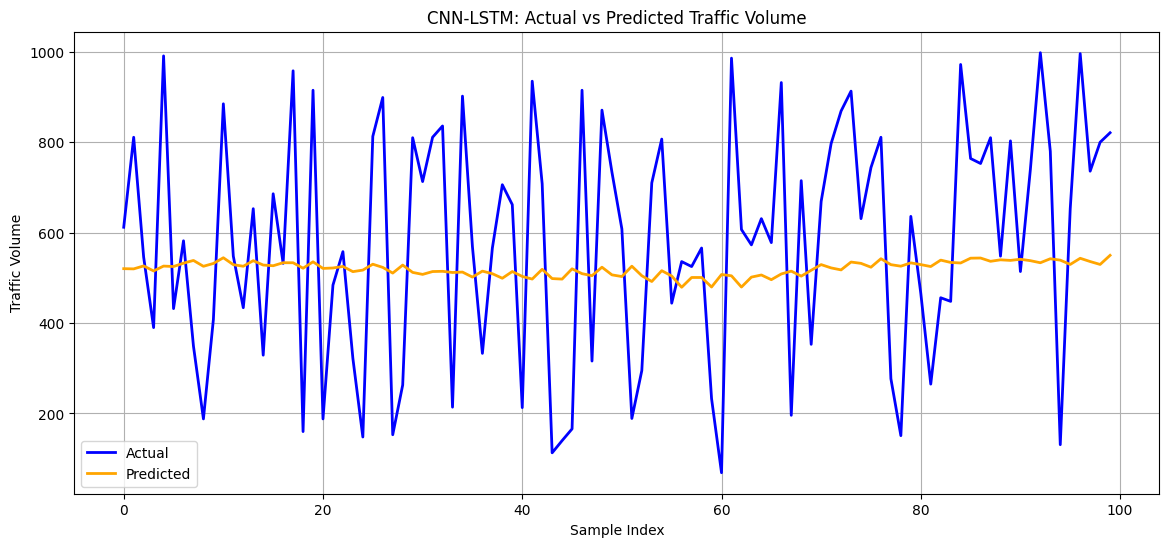

In [7]:
plt.figure(figsize=(14, 6))
plt.plot(y_true[:100], label='Actual', color='blue', linewidth=2)
plt.plot(y_pred[:100], label='Predicted', color='orange', linewidth=2)
plt.title("CNN-LSTM: Actual vs Predicted Traffic Volume")
plt.xlabel("Sample Index")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
print("Last 20 Traffic Volume Predictions vs Actual:")

for i in range(-20, 0):
    actual = y_true[i][0]
    predicted = y_pred[i][0]
    print(f"{len(y_true) + i + 1:4d}) Actual: {actual:.2f}, Predicted: {predicted:.2f}")

Last 20 Traffic Volume Predictions vs Actual:
 368) Actual: 342.00, Predicted: 561.35
 369) Actual: 859.00, Predicted: 576.26
 370) Actual: 962.00, Predicted: 570.33
 371) Actual: 150.00, Predicted: 564.21
 372) Actual: 551.00, Predicted: 571.33
 373) Actual: 353.00, Predicted: 558.34
 374) Actual: 920.00, Predicted: 554.96
 375) Actual: 589.00, Predicted: 565.18
 376) Actual: 602.00, Predicted: 550.29
 377) Actual: 404.00, Predicted: 552.10
 378) Actual: 352.00, Predicted: 559.46
 379) Actual: 545.00, Predicted: 547.83
 380) Actual: 707.00, Predicted: 545.42
 381) Actual: 817.00, Predicted: 562.94
 382) Actual: 276.00, Predicted: 552.21
 383) Actual: 285.00, Predicted: 546.08
 384) Actual: 922.00, Predicted: 551.82
 385) Actual: 941.00, Predicted: 541.28
 386) Actual: 504.00, Predicted: 559.38
 387) Actual: 62.00, Predicted: 556.02


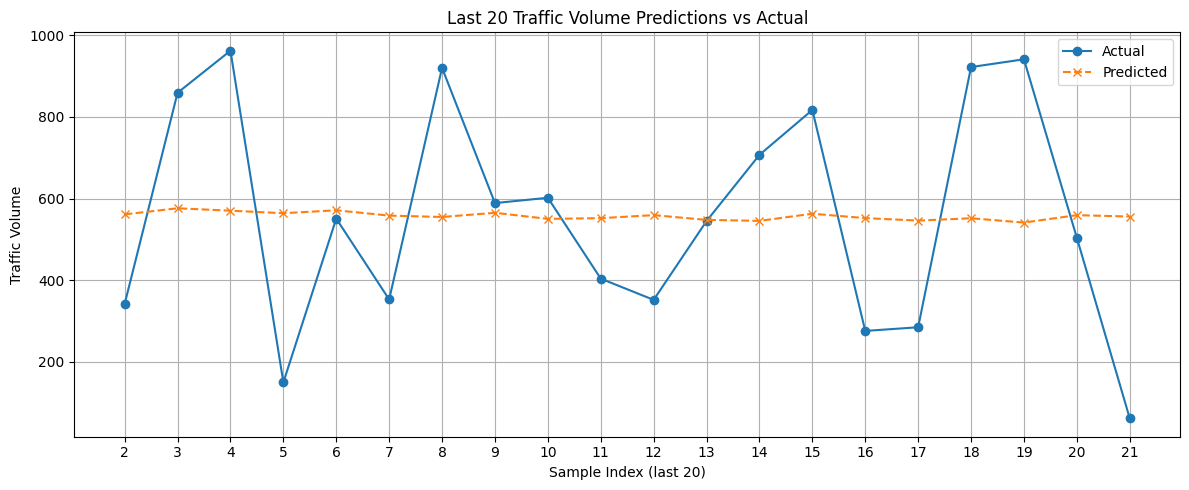

In [9]:
actual_last20 = y_true[-20:].flatten()
predicted_last20 = y_pred[-20:].flatten()

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(actual_last20, label='Actual', marker='o', linestyle='-')
plt.plot(predicted_last20, label='Predicted', marker='x', linestyle='--')
plt.title("Last 20 Traffic Volume Predictions vs Actual")
plt.xlabel("Sample Index (last 20)")
plt.ylabel("Traffic Volume")
plt.xticks(ticks=np.arange(0, 20), labels=[str(i+1) for i in range(1, 21)])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()